In [7]:
library(GenomicRanges)
library(ggplot2)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(ChIPseeker)
library(org.Hs.eg.db)
library(pheatmap)
library(gplots)
library(reshape2)
library(Rmisc)

## Panel A - Annotation of the genomic regions in which eSNPs are located.

>> preparing features information...		 2019-10-10 16:49:06 
>> identifying nearest features...		 2019-10-10 16:49:06 
>> calculating distance from peak to TSS...	 2019-10-10 16:49:06 
>> assigning genomic annotation...		 2019-10-10 16:49:06 
>> adding gene annotation...			 2019-10-10 16:49:07 


'select()' returned 1:many mapping between keys and columns


>> assigning chromosome lengths			 2019-10-10 16:49:07 
>> done...					 2019-10-10 16:49:07 
>> preparing features information...		 2019-10-10 16:49:08 
>> identifying nearest features...		 2019-10-10 16:49:08 
>> calculating distance from peak to TSS...	 2019-10-10 16:49:08 
>> assigning genomic annotation...		 2019-10-10 16:49:08 
>> adding gene annotation...			 2019-10-10 16:49:10 


'select()' returned 1:many mapping between keys and columns


>> assigning chromosome lengths			 2019-10-10 16:49:10 
>> done...					 2019-10-10 16:49:10 


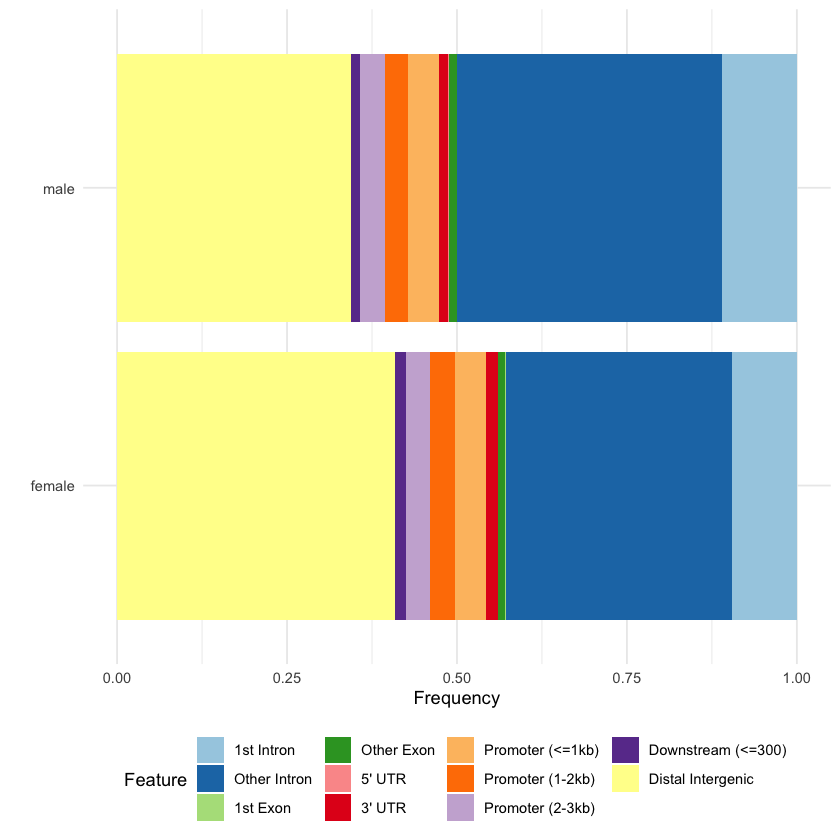

In [5]:
#eQTL data
female <- readRDS("data/fig3A_female_GReQTLs_GRanges.rds")
male <- readRDS("data/fig3A_male_GReQTLs_GRanges.rds")

# annotate peak
ap.female<- annotatePeak(unique(female), TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene, annoDb = "org.Hs.eg.db")
ap.male<- annotatePeak(unique(male), TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene, annoDb = "org.Hs.eg.db")

plot_female= ap.female@annoStat
plot_female$Phenotype ="female"
plot_male= ap.male@annoStat
plot_male$Phenotype ="male"

data_for_plot= rbind(plot_female, plot_male)
data_for_plot$Feature <- factor(data_for_plot$Feature, levels = c("1st Intron",
                                                                  "Other Intron",
                                                                  "1st Exon",#
                                                                  "Other Exon",
                                                                  "5' UTR",#
                                                                  "3' UTR",
                                                                  "Promoter (<=1kb)",
                                                                  "Promoter (1-2kb)",
                                                                  "Promoter (2-3kb)",
                                                                  "Downstream (<=300)",
                                                                  "Downstream (<=3kb)",
                                                                  "Distal Intergenic"))
data_for_plot= rbind(data_for_plot, c("1st Exon","0", "male noLD")) #this is to add 1st exon to ledgend

#pdf("Annotation_Fig3A.pdf")
ggplot(data_for_plot[ -(grep("noLD",data_for_plot$Phenotype)),], aes(Phenotype, as.numeric(Frequency), fill = Feature)) +
  geom_bar(position = "fill", stat = "identity") + scale_fill_brewer(name='Feature', palette = 'Paired') +
  theme_minimal() + theme(legend.position="bottom") + coord_flip()+ylab("Frequency")+xlab("")
#dev.off()


## Panel B - Bar plots showing the overlap of GR-eSNPs and DeepSea annotations, Remap transcript factors (AR and ER) and Encode GR-Chip peaks. 

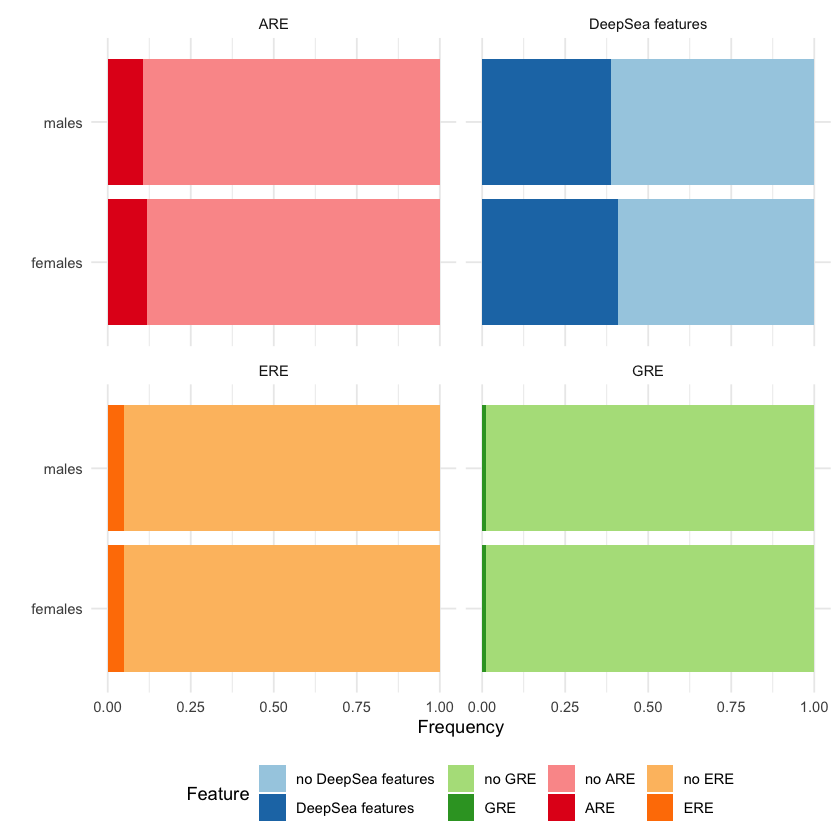

In [6]:
# - DeepSea feature annotation
ds.data <- setNames(data.frame(matrix(ncol = 4, nrow = 0)), c("Feature", "Frequency", "Gender", "Group"))
ds.female <- read.delim("data/fig3B_female_deepSea.evalue",head=T, sep=",")
#dim(ds.female)#1218  925
ds.male <- read.delim("data/fig3B_male_deepSea.evalue", head=T, sep=",")
#dim(ds.male)#[1] 2199  925
fe_sig=ds.female[,-c(1:6)]
fe_sig[fe_sig > 0.01] = 0
fe_sig[fe_sig!=0] = 1
fe_sig$sum=apply(fe_sig, 1,sum)
fe_sig.percent = (dim(fe_sig[fe_sig$sum>0,])[1]*100)/dim(ds.female)[1]
ds.data[1,] = c("DeepSea features", fe_sig.percent, "females", "DeepSea features")
ds.data[2,] = c("no DeepSea features", 100-fe_sig.percent, "females", "DeepSea features")
m_sig=ds.male[,-c(1:6)]
m_sig[m_sig > 0.01]=0
m_sig[m_sig!=0]=1
m_sig$sum=apply(m_sig, 1,sum)
#dim(m_sig[m_sig$sum>0,])#851 = 38.69941%
m_sig.percent = (dim(m_sig[m_sig$sum>0,])[1]*100)/dim(ds.male)[1]
ds.data[3,] = c("DeepSea features", m_sig.percent, "males", "DeepSea features")
ds.data[4,] = c("no DeepSea features", 100-m_sig.percent, "males", "DeepSea features")

# - GRE annotation
gre.female <- readRDS("data/fig3B_female_GReQTLs_GRE.rds")
fe_gre.percent = (length(gre.female@seqnames)*100)/length(female@seqnames)
ds.data[5,] = c("GRE", fe_gre.percent, "females", "GRE")
ds.data[6,] = c("no GRE", 100-fe_gre.percent, "females", "GRE")
gre.male <- readRDS("data/fig3B_male_GReQTLs_GRE.rds")
m_gre.percent = (length(gre.male@seqnames)*100)/length(male@seqnames)
ds.data[7,] = c("GRE", m_gre.percent, "males", "GRE")
ds.data[8,] = c("no GRE", 100-m_gre.percent, "males", "GRE")

# - ARE and ER annotation
are.female <- readRDS("data/fig3B_female_GReQTLs_ARE.rds")
fe_are.percent = (length(are.female@seqnames)*100)/length(female@seqnames)
ds.data[9,] = c("ARE", fe_are.percent, "females", "ARE")
ds.data[10,] = c("no ARE", 100-fe_are.percent, "females", "ARE")
ere.female <- readRDS("data/fig3B_female_GReQTLs_ERE.rds")
fe_ere.percent = (length(ere.female@seqnames)*100)/length(female@seqnames)
ds.data[11,] = c("ERE", fe_ere.percent, "females", "ERE")
ds.data[12,] = c("no ERE", 100-fe_ere.percent, "females", "ERE")

are.male <- readRDS("data/fig3B_male_GReQTLs_ARE.rds")
fe_are.percent = (length(are.male@seqnames)*100)/length(male@seqnames)
ds.data[13,] = c("ARE", fe_are.percent, "males", "ARE")
ds.data[14,] = c("no ARE", 100-fe_are.percent, "males" ,"ARE")
ere.male <- readRDS("data/fig3B_male_GReQTLs_ERE.rds")
fe_ere.percent = (length(ere.male@seqnames)*100)/length(male@seqnames)
ds.data[15,] = c("ERE", fe_ere.percent, "males", "ERE")
ds.data[16,] = c("no ERE", 100-fe_ere.percent, "males", "ERE")

ds.data$Feature <- factor(ds.data$Feature, levels = c("no DeepSea features","DeepSea features","no GRE","GRE","no ARE", "ARE","no ERE","ERE")  )          
#pdf("Annotation_Fig3B.pdf")
ggplot(ds.data, aes(Gender, as.numeric(Frequency), fill = Feature)) +
  geom_bar(position = "fill", stat = "identity") + scale_fill_brewer(name='Feature', palette = 'Paired') +
  theme_minimal() + theme(legend.position="bottom") + coord_flip()+ylab("Frequency")+xlab("")+facet_wrap(~Group)
#dev.off()

## Panel C - Enrichment results for GR-response tag eSNPs and predicted ChromHMM states for sex-stratified tag eSNPs. 

Using EID as id variables
Using EID as id variables


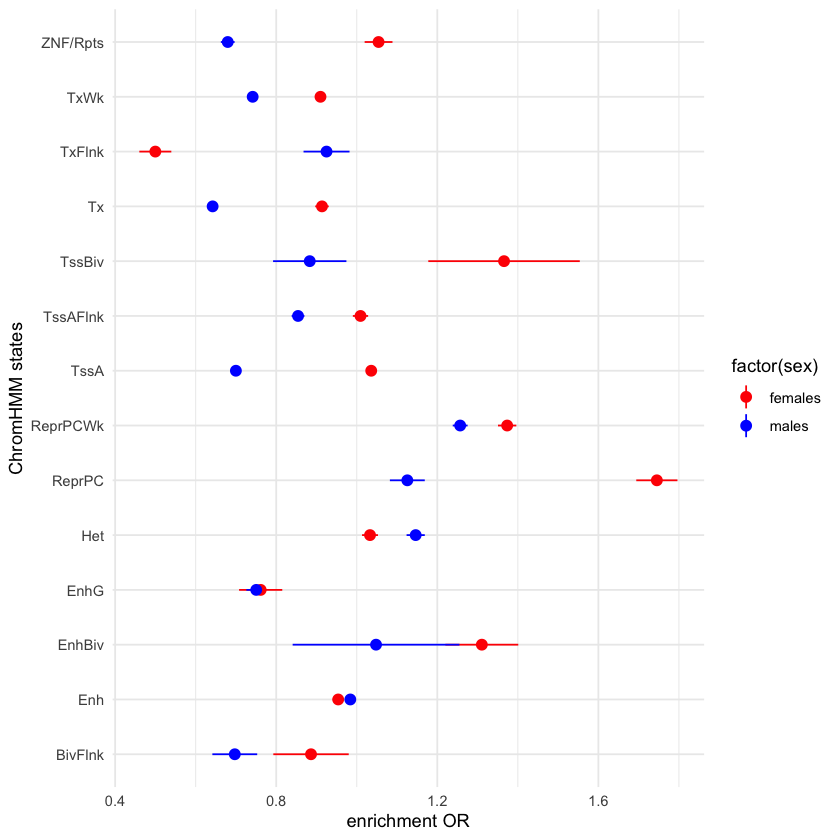

In [9]:
# panel C
fe.or <-read.delim("data/fig3C_female_chromHMM_orMatrix.txt", head=T, check.names = F)
fe.or [fe.or=="Inf"]<-NA
fe.or [fe.or =="-Inf"]<-NA
fe.or.melt=melt(fe.or[,-2])
fe.or.melt$sex = "females"

m.or <- read.delim("data/fig3C_male_chromHMM_orMatrix.txt", head=T, check.names = F)
m.or [m.or=="Inf"]<-NA
m.or [m.or =="-Inf"]<-NA
m.or.melt=melt(m.or[,-2])
m.or.melt$sex = "males"

both=rbind(fe.or.melt, m.or.melt)
both$variable= sapply(as.character(both$variable), function(x) unlist(strsplit(x,"_"))[2])
#pdf("Annotation_Fig3.pdf")
ggplot(both[ both$variable!="Quies",], aes(variable, value)) +  aes(colour = factor(sex))+
  stat_summary(fun.data=mean_se, geom="pointrange", na.rm = T) + 
  labs(y="fold enrichment", x="ChromHMM states") + 
  scale_color_manual(values=c("red", "blue")) +theme_minimal() +  coord_flip()
#dev.off()